# Basic implementation of a dense neural network without using a computational graph
<br>

In this notebook I describe the implementation of a neural network for binary classification and for regression.
The only libraries used here are numpy for math operations and matplotlib to plot the loss over time

In [311]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

### Neural network for classification task

Basically for binary classification tasks, the goal is to predict the probability of an event. For this
purpose : 
<br>
> The last activation function of the network should be sigmoid ($ \sigma(x) =  \frac{1}{1+exp^{-x}}$) to clip the output between 0 and 1.
<br>
> The loss should be the binary cross-entropy 

<br>
<br>
So all the equations of a neural network with only one hidden layer are : 

> Forward propagation : 
<br>

During this step, we compute a weighted sum of an input and weights and pass it to an activation function, here a sigmoid function. We have two layers, the first one outputs the neurons value of the
hidden layer and the second output a prediction ŷ of the propabilities.

\begin{align}
    z_{1} &= X\omega_{1} \\
    fc_{1} &= \sigma(z_{1}) \\
    z_{2} &= fc_{1}\omega_{2} \\
    ŷ &= \sigma(z_{2})
\end{align}


> Loss (binary cross-entropy) :
<br>

We then compare the prediction to the ground truth to see how well our model performs, hence how good is the prediction. 

$$ L = \sum (-y\log(ŷ) + (y-1)\log(1-ŷ)) $$


> Backward propagation : 
<br>

We compute the gradients of the loss with respect to the weights. To do that, we must first compute
the gradient of the loss wrt the predictions and then use the chain rule to "propagate" the gradients.

\begin{align}
   \frac{\partial L}{\partial ŷ} &= -\frac{y}{ŷ} + \frac{(1-y)}{(1-ŷ)} \\
   \frac{\partial L}{\partial z_{2}} &= \frac{\partial L}{\partial ŷ}\frac{\partial ŷ}{\partial z_{2}}  = (ŷ - y)\sigma(z_{2})(1- \sigma(z_{2})) \\
   \frac{\partial L}{\partial fc_{1}} &= \frac{\partial L}{\partial z_{2}}\frac{\partial z_{2}}{\partial fc_{1}}  = (ŷ - y)\sigma(z_{2})(1- \sigma(z_{2}))\omega_{1} \\
   \frac{\partial L}{\partial \omega_{1}} &= \frac{\partial L}{\partial ŷ}\frac{\partial ŷ}{\partial \omega_{1}}  = (ŷ - y)\sigma(z_{2})(1- \sigma(z_{2}))fc_{1} \\
   \frac{\partial L}{\partial \omega_{0}} &= \frac{\partial L}{\partial fc_{1}}\frac{\partial fc_{1}}{\partial \omega_{0}}  = (ŷ - y)\sigma(z_{2})(1- \sigma(z_{2}))\omega_{1}\sigma(z_{1})(1- \sigma(z_{1}))X \\  
\end{align}      

> Weight update: 
<br>

In this final step, the weights are updated using the gradient descent algorithm, based on how much the loss
varies wrt the weights. $ \alpha $ is the learning parameter.

\begin{align}
 \omega_{1} = \omega_{1} - \alpha\frac{\partial L}{\partial \omega_{1}}   \\
 \omega_{0} = \omega_{0} - \alpha\frac{\partial L}{\partial \omega_{0}}   
\end{align}      

### Neural network for regression task

For the regression task, the goal is to predict a continous output, for this reason : 

<br>
> The last activation function of the network can be for example linear (x = x), but shouldn't be constrained to be between 0 and 1.
<br>
> The loss can be for example the MSE, Mean Squared Error ($ L = \frac{1}{2}\sum(y-ŷ)^{2} $).

<br>
Taking this into account, the equations are then similar to the classification task.

<br>
So now let's implement the network with python ! =D

In [318]:
# We define the sigmoid activation function and its derivative used in the backpropagation step
def sigmoid(x) :
    return 1/(1+np.exp(-x))

def sigmoidGradient(x) :
    return sigmoid(x)*(1-sigmoid(x))

In [319]:
# Main class, allowing to train the network (fit method), predict and compute the accuracy for classification tasks
class NN : 
    
    # Constructor 
    def __init__(self, input_neurons, hidden_neurons = 4, nb_epoch = 10000, learning_rate = 0.1, task = "classification") : 
        
        self.nb_epoch = nb_epoch
        self.learning_rate = learning_rate  
        self.task = task  # As we saw earlier this parameter will compute equations depending on the task 
        
        # Weight initialization : 
        # A first weight matrix connecting input layer and hidden layer
        # A second weight matrix connecting hidden layer and output layer
        np.random.seed(42)
        self.W1 = 2*np.random.random((input_neurons, hidden_neurons)) - 1 # Between -1 and 1
        self.W2 = 2*np.random.random((hidden_neurons, 1)) - 1 # Between -1 and 1
    
    
    def fit(self, X, y) : 
        
        # A list that will store the loss for future plot
        loss = []
        
        # Main loop
        for i in range(self.nb_epoch) :


            # Forward propagation
            z1 = np.dot(X, self.W1)
            layer1 = sigmoid(z1)
            z2 = np.dot(layer1, self.W2)
            
            if (self.task == "classification") : 
                y_hat = sigmoid(z2)
            else : # regression
                y_hat = z2  # There is no activation here
                

            
            # Computation of loss and its derivative
            if self.task == "classification" : 
                
                # loss = binary cross-entropy
                loss.append(np.mean(-y*np.log(y_hat)-(1-y)*np.log(1-y_hat)))
                loss_grad_wrt_y_hat = -y*1.0/y_hat + (1.0-y)*1.0/(1.0-y_hat)

            else :  
                
                # loss = "MSE" 
                loss.append(1.0/2.0*np.mean((y - y_hat)**2))
                loss_grad_wrt_y_hat = y_hat - y




            # Backpropagation : Computing the gradients of the loss with respect of the weights using the chain rule
            if self.task == "classification" : 
                loss_grad_wrt_z2 = loss_grad_wrt_y_hat * sigmoidGradient(z2)
            else : 
                loss_grad_wrt_z2 = loss_grad_wrt_y_hat 
                
            loss_grad_wrt_W2 = np.dot(layer1.T, loss_grad_wrt_z2)

            loss_grad_wrt_z1 = np.dot(loss_grad_wrt_z2, self.W2.T) * sigmoidGradient(z1)
            loss_grad_wrt_W1 = np.dot(X.T, loss_grad_wrt_z1)

            
            # Update of the weights using a simple gradient descent algorithm
            self.W2 -= self.learning_rate * loss_grad_wrt_W2
            self.W1 -= self.learning_rate * loss_grad_wrt_W1

            
        return y_hat, loss
    
    
    
    def predict(self, X) :
        
        # Forward propagation
        z1 = np.dot(X, self.W1)
        layer1 = sigmoid(z1)
        z2 = np.dot(layer1, self.W2)
        
        if (self.task == "classification") : 
            y_hat = sigmoid(z2)
        else :  # regression
            y_hat = z2 
        
        return y_hat
    
    
    
    def accuracy(self, y_test, y_pred) : 
        # This method is used for classification tasks
        
        # The prediction vector first need to be transform in a one hot encoding vector
        y_pred = np.where(y_pred>0.5, 1,0) 
        
        nb_equal = np.sum(np.equal(y_test, y_pred))
        nb_samples = len(y_test)
        
        return float(nb_equal)/float(nb_samples)

Last prediction : 
[[0.0047146 ]
 [0.99573371]
 [0.99639048]
 [0.00349475]]

Predicting the XOR output of 0 and 1 : [0.99573418]

Model accuracy : 1.00


 Evolution of the loss wrt to training iterations : 


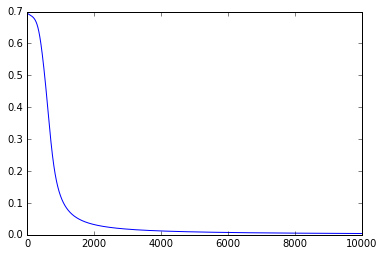

In [325]:
# First example : computing the XOR function which output 1 whenever both inputs are mutually different.

# Input/output initialization 
X = np.array([[0, 0] , [0, 1] , [1, 0] , [1, 1]])
y = np.array([[0, 1, 1, 0]]).T

# model instance with 5 hidden neurons
model1 = NN(input_neurons = 2, hidden_neurons = 5)
y_hat, loss = model1.fit(X,y)

print("Last prediction : \n" + str(y_hat))
print("\nPredicting the XOR output of 0 and 1 : " + str(model1.predict([0,1])))
print("\nModel accuracy : %.2f" %model1.accuracy(y, y_hat))

print("\n\n Evolution of the loss wrt to training iterations : ")
plt.plot(loss[1:])
plt.show()

Model accuracy : 0.93


 Evolution of the loss wrt to training iterations : 


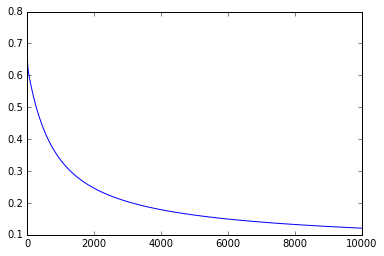

In [331]:
# Second example : Classification of number that are higher that 5.

# Input/output initialization 
n_data = 150
X = np.random.random((n_data,1)) * 10.0  # X is a vector of random value between 0 and 10 
Y = np.where(X>5.0,1,0)

# For this example the dataset is split into a train set and a test set. 
train_split = int(0.8*n_data)
X_train, X_test = X[:train_split], X[train_split:]
y_train, y_test = Y[:train_split], Y[train_split:]


# model instance with 4 hidden neurons and defining a small learning_rate
model2 = NN(input_neurons = 1, hidden_neurons = 4, nb_epoch = 10000, learning_rate = 0.001)
Y_hat, loss = model2.fit(X_train,y_train)

# The test set will be used to evaluate how well the model generalizes, i.e. how it performs on new, unseen data
print("Model accuracy : %.2f" %model2.accuracy(y_test, model2.predict(X_test)))

print("\n\n Evolution of the loss wrt to training iterations : ")
plt.plot(loss[1:])
plt.show()

Predictions on the test set : 
[[0.99751521]
 [0.68549588]
 [1.76690578]
 [2.02546824]]

Actual output of the test set : 
[[0.93511044]
 [0.67958835]
 [1.78490326]
 [2.03843064]]

Mean absolute error : 0.02


 Evolution of the loss wrt to training iterations : 


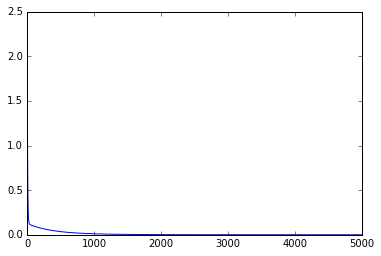

In [336]:
# Third and last example : Computing the sum of 3 float (this is a regression task)


# Input/output initialization 
n_data = 20
X = np.random.random((n_data,3)) 
Y = np.sum(X,axis = 1)
Y = Y[:,None] # Just ensuring the array dimension is [n_data, 1]


# The dataset is split into a train set and a test set. 
train_split = int(0.8*n_data)
X_train, X_test = X[:train_split], X[train_split:]
y_train, y_test = Y[:train_split], Y[train_split:]


# model instance with 20 hidden neurons 
model3 = NN(input_neurons = 3,
            hidden_neurons = 20,
            nb_epoch = 5000,
            learning_rate = 0.001,
            task = "regression")

Y_hat, loss = model3.fit(X_train,y_train)

print("Predictions on the test set : \n" + str(model3.predict(X_test)))
print("\nActual output of the test set : \n" + str(y_test))

print("\nMean absolute error : %.2f" %np.mean(np.abs(y_test - model3.predict(X_test))))

print("\n\n Evolution of the loss wrt to training iterations : ")
plt.plot(loss[1:])
plt.show()